Last updated: 27 Jul 2018

# Exploring US Endangered Species Data with Python

This notebook retrieves data from the US Fish & Wildlife Service on endangered and threatened species. It runs a simple analysis and returns a visualization of types and locations of species.

In [73]:
%matplotlib inline
from bs4 import BeautifulSoup 
import pandas as pd
import re, requests
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

## Data Source

Data are retrieved from the U.S. Fish & Wildlife Service [Environmental Conservation Online System](https://ecos.fws.gov/ecp/), which reports on Threatened & Endangered species in the United Statesthat are protected by the Endangered Species Act. 

There are a number of different reports are available here: https://ecos.fws.gov/ecp/species-reports. They are mostly provided as sortable tables, viewable online.

## What question are we asking?

After looking at some of the available datasets, it seems like there are data available on how many requests were made to list species, when species were officially listed, and in what US states they can be found.

For the purposes of this analysis, I would like to ask the following questions:

> *1. Which US states are most effective at getting species listed under the Endangered Species Act?*

> *2. How has the rate of getting species listed changed over time?*

## 1. Which US states are most effective at getting species listed under the Endangered Species Act?



## 2. Listing species over time



We can scrape the [U.S. Federal Endangered and Threatened Species by Calendar Year](https://ecos.fws.gov/ecp0/reports/species-listings-count-by-year-report) report to get counts of species listed by year. 

In [2]:
url = 'https://ecos.fws.gov/ecp0/reports/species-listings-count-by-year-report'
r = requests.get(url)
soup = BeautifulSoup(r.text, "html5lib")
rows = soup.table.find_all('tr')
listing_years = set()
for row in rows:
    values = row.find_all('td')
    if len(values) > 0:
        listing_years.add(values[0].string)
listing_years = sorted(list(listing_years))
print(", ".join(listing_years))

1967, 1970, 1972, 1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018


Unfortunately, there is some redundancy in the reported counts, so we can't rely on these numbers alone to get accurate counts. We can get a list of reported years.

We can take the list of years we determined from the last step, and query the [Species Listed During Calendar Year](https://ecos.fws.gov/ecp0/reports/species-listings-by-year-report?year=2018) reports for each year in `listing_years`.

In [3]:
url = 'https://ecos.fws.gov/ecp0/reports/species-listings-by-year-report'
all_species = []
for y in listing_years:
    params = {'year': y}
    r = requests.get(url, params)
    soup = BeautifulSoup(r.text, "html5lib")
    rows = soup.table.find_all('tr')
    for row in rows:
        species = {}
        data = row.find_all('td')
        if len(data) > 0:
            splink = data[2].a['href']
            spcode = re.findall('spcode=(\w{4})', splink)[0]
            species['spcode'] = spcode
            species['sciname'] = data[2].string
            species['status'] = data[3].string
            species['listyear'] = y
            all_species.append(species)
print(f'{len(all_species)} species records read from Species Listed During Calendar Year')

3579 species records read from Species Listed During Calendar Year


We can take the `all_species` records and put them into a pandas DataFrame. We can also drop the duplicate values that were throwing off the original counts.

In [4]:
df_years = pd.DataFrame(all_species)
df_years = df_years[['spcode', 'sciname', 'status', 'listyear']]
df_years = df_years.drop_duplicates()
print(f'{len(df_years)} species records remaining after dropping duplicates')

1811 species records remaining after dropping duplicates


Summarize the data table - counts by year

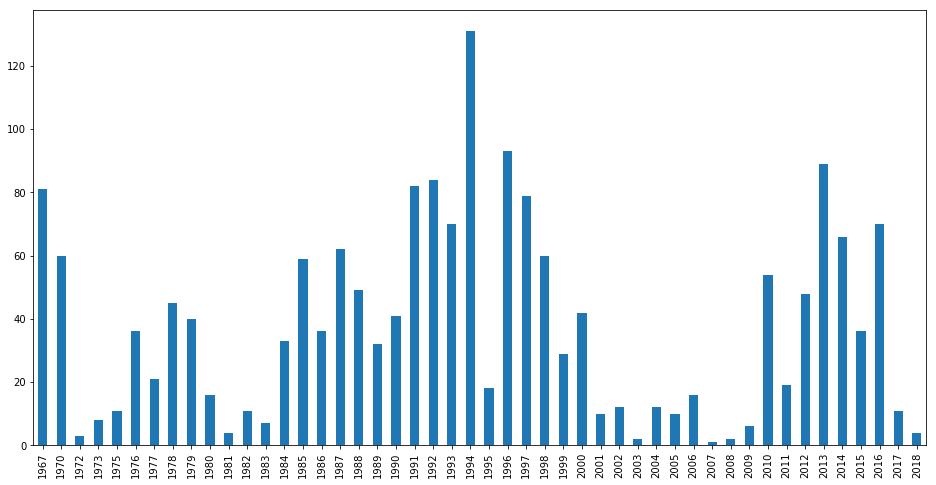

In [74]:
year_counts = df_years['listyear'].value_counts().sort_index()
year_counts.plot(kind='bar');

In [22]:
url = 'https://ecos.fws.gov/ecp/report/table/petitions-received.json'
params = {'active': 'any'}
r = requests.get(url, params).json()

In [23]:
columnheaders = [x['title'] for x in r['metadata']['columns']]
print(columnheaders)

['Petition Title', 'Date Received by the FWS', 'Where the species is believed to or known to occur', 'Petitioner Name', 'Requested Action', 'Petition Finding(s)', 'Active', 'Petitions Document(s)']


In [45]:
def parseSpeciesNumber(petitionTitle):
    nspecies = re.findall('\d+', petitionTitle)
    if len(nspecies) > 0:
        return int(nspecies[0])
    else:
        return 1

In [61]:
df_petitions = pd.DataFrame(r['data'], columns=columnheaders)
df_petitions['year_received'] = df_petitions.apply(lambda x: x['Date Received by the FWS'][-4:], axis=1)
df_petitions['n_species'] = df_petitions.apply(lambda x: parseSpeciesNumber(x['Petition Title']), axis=1)
df_petitions.at[576, 'n_species'] = 1
df_petitions.at[577, 'n_species'] = 1
df_petitions.at[582, 'n_species'] = 1
df_petitions.at[598, 'n_species'] = 1
df_petitions.at[715, 'n_species'] = 1
df_petitions

,Petition Title,Date Received by the FWS,Where the species is believed to or known to occur,Petitioner Name,Requested Action,Petition Finding(s),Active,Petitions Document(s),year_received,n_species
0,Petition to List the Dunes Sagebrush Lizard as...,06/01/2018,"NM, TX","[Center for Biological Diversity, Defenders of...","[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List the Dunes Sagebrus...,2018,1
1,Petition to List U.S. Populations of Lake Stur...,05/23/2018,"AL, AR, GA, IA, IL, IN, KS, KY, LA, MI, MN, MO...",[Center for Biological Diversity],"[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List U.S. Populations o...,2018,1
2,Petition to List the Siskiyou Mountains Salama...,03/12/2018,"CA, OR","[Cascadia Wildlands, Center for Biological Div...","[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List the Siskiyou Mount...,2018,1
3,Yellowstone Bison DPS,03/05/2018,"CO, IA, MT, OK, SD, UT, WY, Canada, Mexico, Un...",[James Horsley],"[Listing: Threatened, APA: Designate Critical ...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Yellowstone Bison Petition Volume 2...,2018,1
4,PETITION TO LIST THE REFUGIO MANZANITA (ARCTOS...,11/30/2017,CA,"[Los Padres ForestWatch, The Chaparral Institu...","[Listing: Endangered, APA: Designate Critical ...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'PETITION TO LIST THE REFUGIO MANZAN...,2017,1
5,PETITION TO LIST OREGON VESPER SPARROW (Pooece...,11/08/2017,"CA, OR, WA",[American Bird Conservancy ],"[Listing: Threatened, APA: Designate Critical ...","[{'name': '90 Day Substantial on 06/27/2018', ...",Yes,"[{'name': 'Oregon Vesper Sparrow Petition', 'u...",2017,1
6,"Toad, Dixie Valley (Bufo (Anaxyrus) williamsi)",09/18/2017,"NV, United States",[Center for Biological Diversity],[Listing: Threatened or Endangered],"[{'name': '90 Day Substantial on 06/27/2018', ...",Yes,[{'name': 'Notification to State of Nevada of ...,2017,1
7,"Horse, Pryor Mountain Mustang DPS",06/19/2017,"AZ, CA, ID, MT, NM, NV, OK, UT, WY",[Friends of Animals],[Listing: Threatened or Endangered],[],No,"[{'name': 'Mustang Petition Cover Letter', 'ur...",2017,1
8,Giraffe; List T/E,04/20/2017,"Cameroon, Central African Republic, Chad, Ethi...","[CBD, HSI, HSIUS, IFAW, NRDC]",[Listing: Threatened or Endangered],"[{'name': 'Petition findings not yet made', 'u...",Yes,"[{'name': 'Giraffe Petition', 'url': '/docs/pe...",2017,1
9,Yellowstone bison DPS,01/13/2017,"CO, IA, MT, OK, SD, UT, WY, Canada, Mexico, Un...",[James Horsley],[Listing: Threatened or Endangered],[{'name': '90 Day Not Substantial on 01/12/201...,No,"[{'name': 'Yellowstone Bison Petition', 'url':...",2017,1


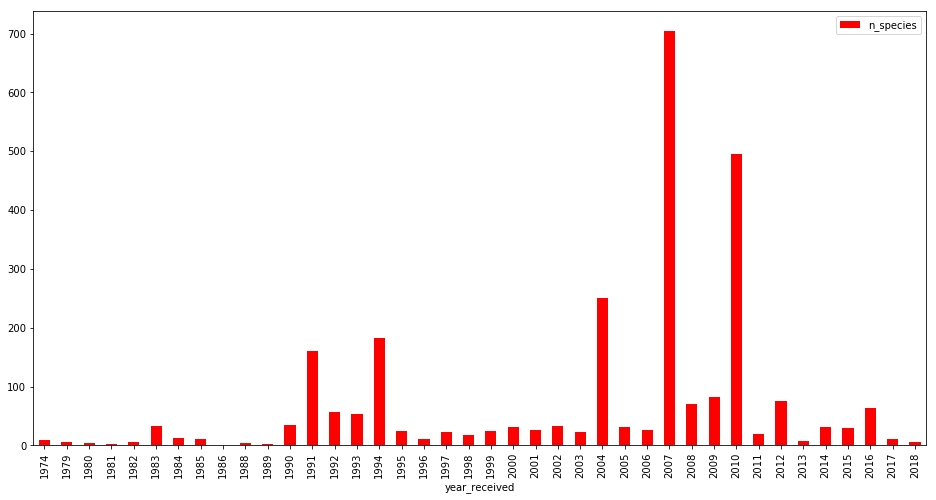

In [75]:
petitions_per_year = df_petitions[['year_received', 'n_species']].groupby('year_received').sum()
petitions_per_year.plot(kind='bar', color='red');

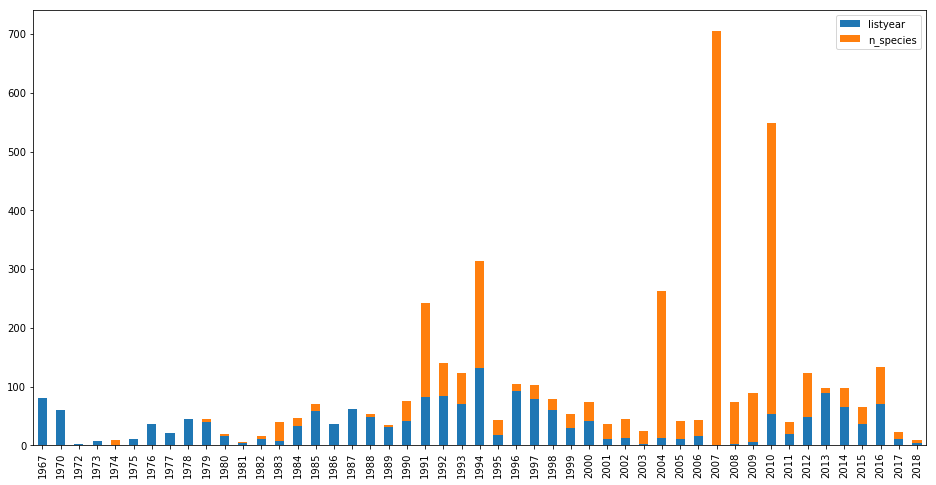

In [76]:
df_percents = pd.concat([year_counts, petitions_per_year], axis=1).fillna(0)
df_percents.plot.bar(stacked=True);

In [ ]:
url = 'https://ecos.fws.gov/ecp0/reports/ad-hoc-species-report'
params = {
    'kingdom': 'V', 'kingdom': 'I', 'kingdom': 'P',
    'status': 'E', 'status': 'T',
    'mapstatus': 3, 
    'fstatus': 'on', 'finvpop': 'on', 'fgroup': 'on', 'ffamily': 'on',
    'header': 'Listed Vertebrates, Invertebrates, and Plants'
}
r = requests.get(url, params)
with open('endangered_threatened_species.txt', 'w') as f:
    f.write(r.text)